In [1]:
!pip install wandb
!pip install einops
!pip install matplotlib
!wandb login ...

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
from smolgpt import *

### load dataset, create encoder and decoder

In [3]:
text = open('gameofthrones.txt', 'r').read()
print(f'size of the text: {len(text)} characters')

size of the text: 5662324 characters


In [4]:
vocab = sorted(list(set(text)))
print(f'size of the vocabulary: {len(vocab)} characters')
''.join(vocab)

size of the vocabulary: 86 characters


'\n !(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz{}éê—‘’“”…'

In [5]:
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}
encode = lambda string: [stoi[x] for x in string]
decode = lambda ids: ''.join([itos[x] for x in ids])

# test
print(decode(encode('Hello, World!')))
print(encode(decode([1, 2, 3, 4, 5])))

Hello, World!
[1, 2, 3, 4, 5]


In [6]:
train_ids = encode(text)
# character-level encoding => this equality should hold
assert len(train_ids) == len(text)
# convert to tensor
train_ids = torch.tensor(train_ids)

In [7]:
def get_batch(batch_size, l, device):
  ids = random.choices(range(len(train_ids) - l - 1), k=batch_size) 
  batch = torch.stack([train_ids[i:i + l + 1] for i in ids])
  return batch[:, :-1].to(device), batch[:, 1:].to(device)

In [8]:
d = 16 * 16
nh = 16
nl = 16
l = 256
v = len(vocab)
batch_size = 32
steps = 25000
interval = 100
lr = 3e-4

if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [9]:
model = GPT(d, nh, nl, l, v).to(device)
print(f'size of the model: {model.size} parameters')
optimizer = Adam(model.parameters(), lr=lr)

size of the model: 12729408 parameters


### train loop

In [10]:
wandb.init(project='Game of Thrones GPT')

losses = []
scaler = GradScaler()
s = time()
for i in range(1, steps + 1):
  # fp16 training
  with autocast():
    loss = model.loss(*get_batch(batch_size, l, device))
  # logging
  losses.append(loss.item())
  wandb.log({'loss': losses[-1]})
  if i % interval == 0:
    avg_loss = sum(losses[-interval:]) / interval 
    print(f'loss: {avg_loss}\tstep: {i}\ttime: {time() - s}s')
    s = time()
  # training step
  scaler.scale(loss).backward()
  scaler.step(optimizer)
  scaler.update()
  optimizer.zero_grad()

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akbirthko. Use `wandb login --relogin` to force relogin


loss: 2.690992419719696	step: 100	time: 12.20459508895874s
loss: 2.3860298371315003	step: 200	time: 11.371003150939941s
loss: 2.337511296272278	step: 300	time: 12.047192096710205s
loss: 2.2524799418449404	step: 400	time: 13.956527948379517s
loss: 2.1438724780082703	step: 500	time: 13.65282154083252s
loss: 2.023418991565704	step: 600	time: 13.334108829498291s
loss: 1.9031676721572877	step: 700	time: 13.402865886688232s
loss: 1.801775450706482	step: 800	time: 13.355583429336548s
loss: 1.7181529629230499	step: 900	time: 13.471343755722046s
loss: 1.6528722178936004	step: 1000	time: 11.933260679244995s
loss: 1.5929857194423676	step: 1100	time: 11.211866617202759s
loss: 1.5427118825912476	step: 1200	time: 13.646666049957275s
loss: 1.4926905512809754	step: 1300	time: 12.804261922836304s
loss: 1.4559193241596222	step: 1400	time: 11.523555517196655s
loss: 1.4208185756206513	step: 1500	time: 12.969670057296753s
loss: 1.3919748055934906	step: 1600	time: 13.581393241882324s
loss: 1.365042681694030

loss,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
loss,0.53559


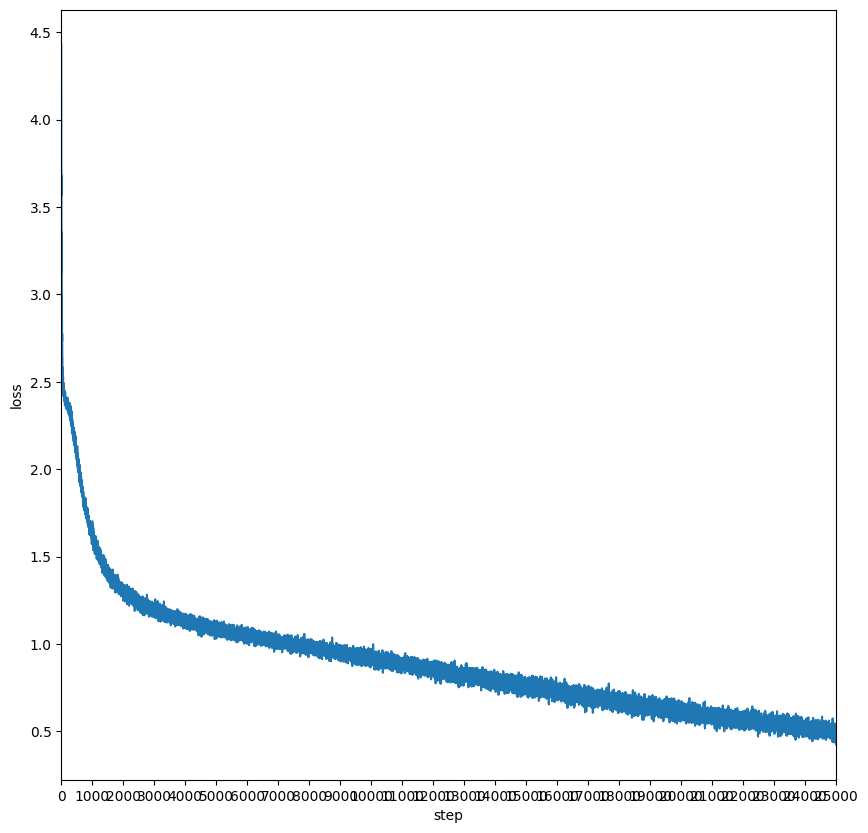

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim(0, steps)
plt.xticks(list(range(0, steps + 1000, 1000)))
plt.plot(list(range(steps)), losses)

### test the model

In [12]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0
  print(text, end='')
  it = torch.tensor(encode(text)).to(device)  # input tokens
  with torch.no_grad():
    for _ in range(n):
      p = F.softmax(model(it[-model.l:]) / temp, -1)[-1]  # prob distribution
      t = torch.multinomial(p, 1)  # next token
      it = torch.cat((it, t), -1)  # concatenate with prev tokens
      text += decode([t.item()])  # concatenate with prompt
      print(text[-1], end='')
    return text, it  # return completed text and tokens

In [13]:
_ = generate(model, 'Harry and Hagrid entered Diagon Alley', 500, device=device)

Harry and Hagrid entered Diagon Alley, noted that a longer place before him when he came upon more silk through the floor of the blood- on her bare shaggy grey hair. “Sansa,” he said, “but she’s kissed.”

The seemed to stir him, as if he had been so glad to say.

Bran shoved suspiciously. “He likes. I could, to live. I offer the gods.”

“He realized a dog in desire.” He laughed.

“As you say, but… what of his sisters?”

“When he came forward to Lord Baelish, once. Haider the Kingsguard sat the Boltons by the arms, letting the fligh

In [14]:
_ = generate(model, 'Voldemort cast his wand aside and', 500, device=device)

Voldemort cast his wand aside and said, “Come as good as good as noble.”

And so it spread his eyes. Jojen Reed steel in the deep as his protection annoying that had his auburn had had felt from him, and this was strange good. He had dressed the wine, but neither skins, nor black, nor big enough to make his whole life in it, or to keep him safe, pledge him under the castle. They began to go back to him, he thought. He had the way on a beating of black cloaks never fancied to Daeron’s squire the night, yet it seemed as though he

In [15]:
_ = generate(
  model,
  'Dumbledore sent a blast of fire from his wand direct at Voldemort',
  4000,
  temp=0.8,
  device=device
)

Dumbledore sent a blast of fire from his wand direct at Voldemort, in a red tree, drunk men like Aegon Umber, and slain by his son Harrenhal. His father had married of singers, or some of Tarth. He could go to Roose Bolton, and ashead him Sansa as well. But what do we call Bran and do with him? My sister is young Viserys Spider, was strong, and perhaps I would be gathered and very present worthy of her uncle Arya and her child?”

“I know the boy was,” she said in the Common Tongue of the Seven Kingdoms thought she could not have the same. “She has a good visit to this, Mudge. Aggo said about her name was Vayonbe when the Ign does not awake.”

“What would he want him? The khal will never do this, and the stream below him down.”

Meera rose to her feet, but before they could only be men. “I wish to come here to this brother.”

“Be queen patient,” her handmaid Irri said, rising the arm through a striped black dogshes and bacon to Daenerys. “I believe I am.”

“Yes,” he said shrillingly. “I

### save the model checkpoint

In [16]:
torch.save(model.state_dict(), 'GoT-model.pt')